In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import gc

In [3]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()

In [4]:
train_trans = pd.read_csv("/content/drive/MyDrive/프로젝트/train_transaction.csv")
train_idf = pd.read_csv("/content/drive/MyDrive/프로젝트/train_identity.csv")
test_trans = pd.read_csv("/content/drive/MyDrive/프로젝트/test_transaction.csv")
test_idf = pd.read_csv("/content/drive/MyDrive/프로젝트/test_identity.csv")

In [33]:
total_trans.card5.nunique()

138

In [31]:
total_trans.card3.value_counts().sort_values(ascending = False)

card3
150.0    956845
185.0    109960
106.0      3543
117.0      2841
144.0      2633
146.0      2470
143.0      1670
102.0      1198
119.0      1091
162.0      1039
147.0       868
203.0       599
213.0       554
100.0       529
188.0       502
134.0       440
131.0       391
149.0       337
229.0       334
200.0       326
197.0       270
195.0       267
210.0       257
135.0       233
121.0       227
159.0       192
215.0       183
223.0       181
138.0       179
141.0       146
137.0       141
148.0       124
214.0       118
133.0        98
166.0        96
212.0        88
204.0        87
142.0        86
190.0        85
198.0        84
194.0        79
111.0        78
182.0        67
199.0        59
177.0        58
222.0        52
225.0        49
136.0        48
217.0        45
127.0        42
180.0        41
114.0        41
130.0        40
129.0        35
211.0        34
189.0        34
152.0        33
191.0        29
101.0        28
126.0        27
227.0        24
168.0        21
11

In [54]:
total_trans = pd.concat([train_trans, test_trans], axis = 0)

In [30]:
total_trans.card5.value_counts().sort_values(ascending = False)

card5
226.0    553537
224.0    153109
166.0    102930
102.0     49491
117.0     47061
138.0     41839
195.0     31896
126.0     21737
137.0     19450
219.0     18326
162.0      9036
202.0      7103
229.0      4744
223.0      3460
197.0      3165
150.0      2550
118.0      1447
190.0      1396
100.0      1323
146.0      1259
183.0      1247
198.0      1212
236.0      1187
185.0       965
147.0       828
203.0       815
141.0       694
129.0       691
228.0       500
189.0       471
132.0       382
131.0       362
144.0       358
119.0       337
135.0       331
142.0       309
194.0       281
133.0       262
134.0       258
177.0       218
232.0       144
207.0       132
213.0       130
149.0       110
237.0       107
222.0       101
215.0        95
111.0        80
143.0        79
159.0        66
184.0        60
212.0        54
188.0        53
199.0        47
104.0        43
182.0        30
127.0        25
168.0        25
139.0        24
114.0        24
225.0        24
130.0        22
10

In [5]:
train_trans['TransactionDay'] = train_trans['TransactionDT'] // (24 * 60 * 60)
test_trans['TransactionDay'] = test_trans['TransactionDT'] // (24 * 60 * 60)

In [6]:
train_idf.columns = [col.replace('-', '_') if 'id' in col else col for col in train_idf.columns]
test_idf.columns = [col.replace('-', '_') if 'id' in col else col for col in test_idf.columns]

In [7]:
for col in train_trans.columns:
    for i in range(1, 16):
      if i != 9:
        train_trans[f'D{i}N'] = train_trans['TransactionDay'] - train_trans[f'D{i}']
        test_trans[f'D{i}N'] = test_trans['TransactionDay'] - test_trans[f'D{i}']

In [10]:
train_df = pd.merge(train_trans, train_idf, how='left', on = 'TransactionID')
test_df = pd.merge(test_trans, test_idf, how='left', on = 'TransactionID')

In [11]:
id_feature = [ c for c in train_df.columns if c.find('id_') !=-1]
v_feature = [ c for c in train_df.columns if c.find('V') !=-1]
card_feature = [ c for c in train_df.columns if c.find('card') !=-1]
C_feature = [ c for c in train_df.columns if c.find('C') !=-1 and c != 'ProductCD']
D_feature = [ c for c in train_df.columns if c.find('n') == -1 and c.find('D') !=-1 and c not in ['ProductCD','TransactionID','TransactionDT','DeviceType','DeviceInfo','TransactionDay']]
Dn_feature = [ c for c in train_df.columns if c.find('n') != -1 and c.find('D') !=-1 and c not in ['ProductCD','TransactionID','TransactionDT','DeviceType','DeviceInfo','TransactionDay']]
M_feature = [ c for c in train_df.columns if c.find('M') !=-1]

In [71]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
train_trans['DT_M'] = train_trans['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
test_trans['DT_M'] = test_trans['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
train_trans['DT_M'] = (train_trans['DT_M'].dt.year-2017)*12 + train_trans['DT_M'].dt.month
test_trans['DT_M'] = (test_trans['DT_M'].dt.year-2017)*12 + test_trans['DT_M'].dt.month

In [18]:
# 그룹화 및 집계
grouped = train_trans.groupby(['card1', 'addr1', 'DT_M'])['dist1'].agg(['mean', 'std']).reset_index()
grouped2 = test_trans.groupby(['card1', 'addr1', 'DT_M'])['dist1'].agg(['mean', 'std']).reset_index()

# 컬럼 이름 변경
grouped.columns = ['card1', 'addr1', 'DT_M', 'dist1_mean', 'dist1_std']
grouped2.columns = ['card1', 'addr1', 'DT_M', 'dist1_mean', 'dist1_std']

train_trans = test_trans.merge(grouped, on=['card1', 'addr1', 'DT_M'], how='left')
test_trans = test_trans.merge(grouped2, on=['card1', 'addr1', 'DT_M'], how='left')

In [ ]:
# 그룹화 및 집계
grouped = train_trans.groupby(['card1', 'addr1', 'DT_M'])['C13'].agg(['mean', 'std']).reset_index()
grouped2 = test_trans.groupby(['card1', 'addr1', 'DT_M'])['C13'].agg(['mean', 'std']).reset_index()

# 컬럼 이름 변경
grouped.columns = ['card1', 'addr1', 'DT_M', 'C13_mean', 'C13_std']
grouped2.columns = ['card1', 'addr1', 'DT_M', 'C13_mean', 'C13_std']

train_trans = test_trans.merge(grouped, on=['card1', 'addr1', 'DT_M'], how='left')
test_trans = test_trans.merge(grouped2, on=['card1', 'addr1', 'DT_M'], how='left')

In [20]:
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [86]:
def encode_CB(col1,col2,df1=train_trans,df2=test_trans):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

In [25]:
def encode_LE(col,train=train_trans,test=test_trans,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

In [84]:
def encode_AG(main_columns, uids, aggregations=['mean'], train_df = train_trans, test_df = test_trans,
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

In [ ]:
encode_AG([''])

In [ ]:
def encode_AG2(main_columns, uids, train_df=train_trans, test_df=test_trans):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col, main_column]],test_df[[col, main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [ ]:
main_ = []
uids = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'TransactionID', 'P_emaildomain', ]

In [82]:
M_feature = [ c for c in train_df.columns if c.find('M') !=-1 and c.find('M') != -1 and c not in ['DT_M']]

In [83]:
mapping = {'T': 1, 'F': 0, 'M0': 0, 'M1': 1, 'M2': 2}
for col in M_feature:
    train_trans[col] = train_trans[col].map(mapping)
    test_trans[col] = test_trans[col].map(mapping)

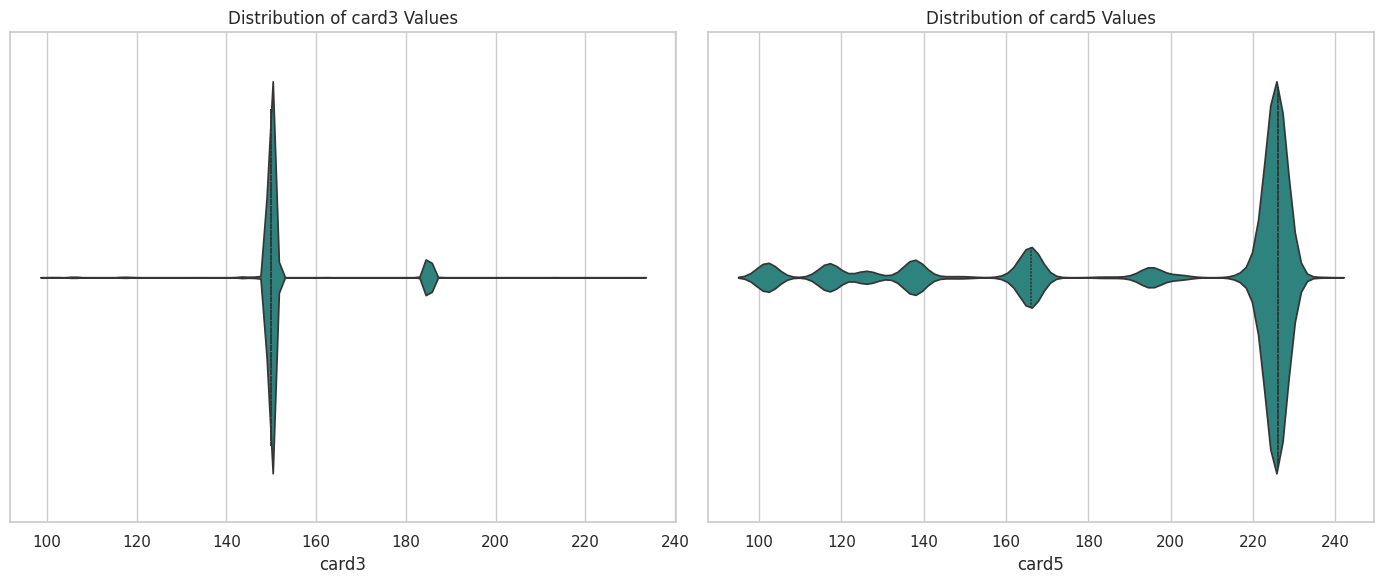

In [35]:
# 인덱스 재설정
total_trans = total_trans.reset_index(drop=True)

# 바이올린 플롯을 사용하여 card3과 card5의 분포 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='card3', data=total_trans, inner="quartile", palette="viridis")
plt.title('Distribution of card3 Values')

plt.subplot(1, 2, 2)
sns.violinplot(x='card5', data=total_trans, inner="quartile", palette="viridis")
plt.title('Distribution of card5 Values')

plt.tight_layout()
plt.show()

In [39]:
total_trans.card2.value_counts().sort_values(ascending = False)

card2
321.0    91731
111.0    82537
555.0    80404
490.0    70496
583.0    41503
         ...  
293.0      126
121.0      126
419.0      126
552.0      125
487.0      123
Name: count, Length: 501, dtype: int64

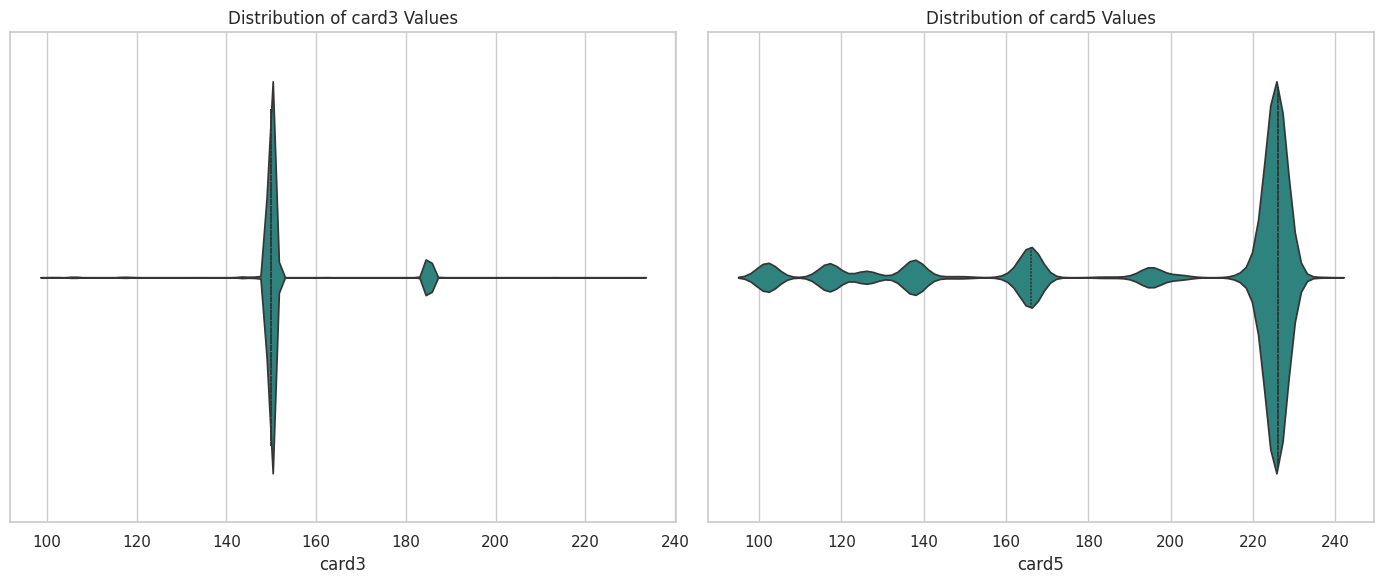

count    17091.000000
mean         1.002984
std          0.185937
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: card5, dtype: float64


In [36]:
# 바이올린 플롯을 사용하여 card3과 card5의 분포 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='card3', data=total_trans, inner="quartile", palette="viridis")
plt.title('Distribution of card3 Values')

plt.subplot(1, 2, 2)
sns.violinplot(x='card5', data=total_trans, inner="quartile", palette="viridis")
plt.title('Distribution of card5 Values')

plt.tight_layout()
plt.show()

# 고객별 card5 값 분포
customer_card5_dist = total_trans.groupby('card1')['card5'].nunique()
print(customer_card5_dist.describe())

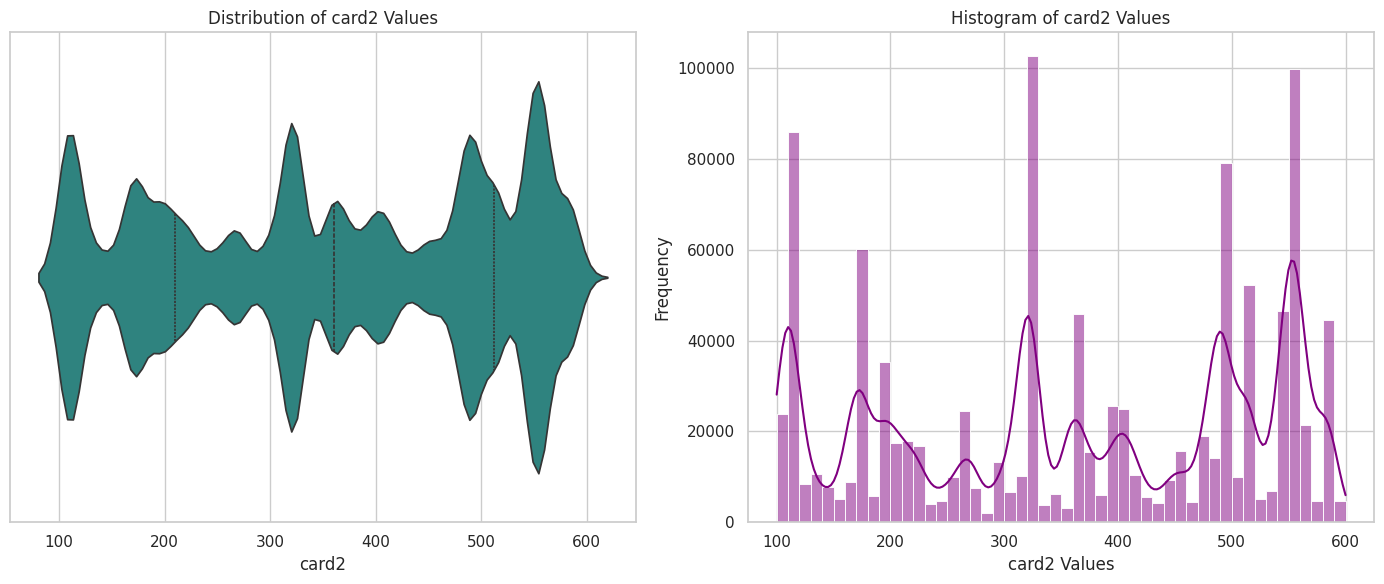

Number of unique values in card2: 501
card2
321.0    91731
111.0    82537
555.0    80404
490.0    70496
583.0    41503
170.0    33411
545.0    31894
194.0    31511
514.0    27225
360.0    26532
174.0    21406
512.0    19884
408.0    17160
361.0    14420
215.0    13801
100.0    13651
399.0    13458
225.0    13274
553.0    12202
375.0    12157
Name: count, dtype: int64


In [40]:
# 인덱스 재설정
total_trans = total_trans.reset_index(drop=True)

# 바이올린 플롯을 사용하여 card2의 분포 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='card2', data=total_trans, inner="quartile", palette="viridis")
plt.title('Distribution of card2 Values')

plt.subplot(1, 2, 2)
sns.histplot(total_trans['card2'], bins=50, kde=True, color='purple')
plt.title('Histogram of card2 Values')
plt.xlabel('card2 Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# card2 값의 고유 개수 확인
unique_card2_values = total_trans['card2'].nunique()
print(f"Number of unique values in card2: {unique_card2_values}")

# card2 값의 빈도수 확인
card2_counts = total_trans['card2'].value_counts()
print(card2_counts.head(20))  # 상위 20개의 값을 출력

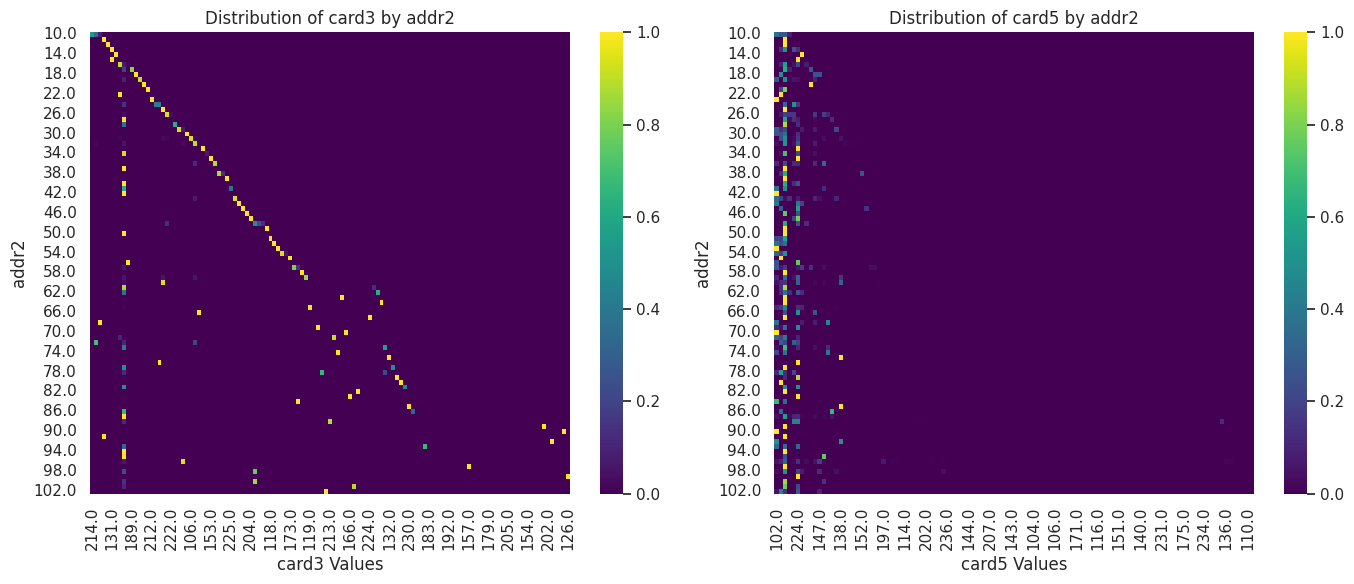

In [41]:

# addr2와 card3, card5의 관계 분석
addr2_card3 = total_trans.groupby('addr2')['card3'].value_counts(normalize=True).unstack().fillna(0)
addr2_card5 = total_trans.groupby('addr2')['card5'].value_counts(normalize=True).unstack().fillna(0)

# 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(addr2_card3, cmap='viridis')
plt.title('Distribution of card3 by addr2')
plt.xlabel('card3 Values')
plt.ylabel('addr2')

plt.subplot(1, 2, 2)
sns.heatmap(addr2_card5, cmap='viridis')
plt.title('Distribution of card5 by addr2')
plt.xlabel('card5 Values')
plt.ylabel('addr2')

plt.tight_layout()
plt.show()

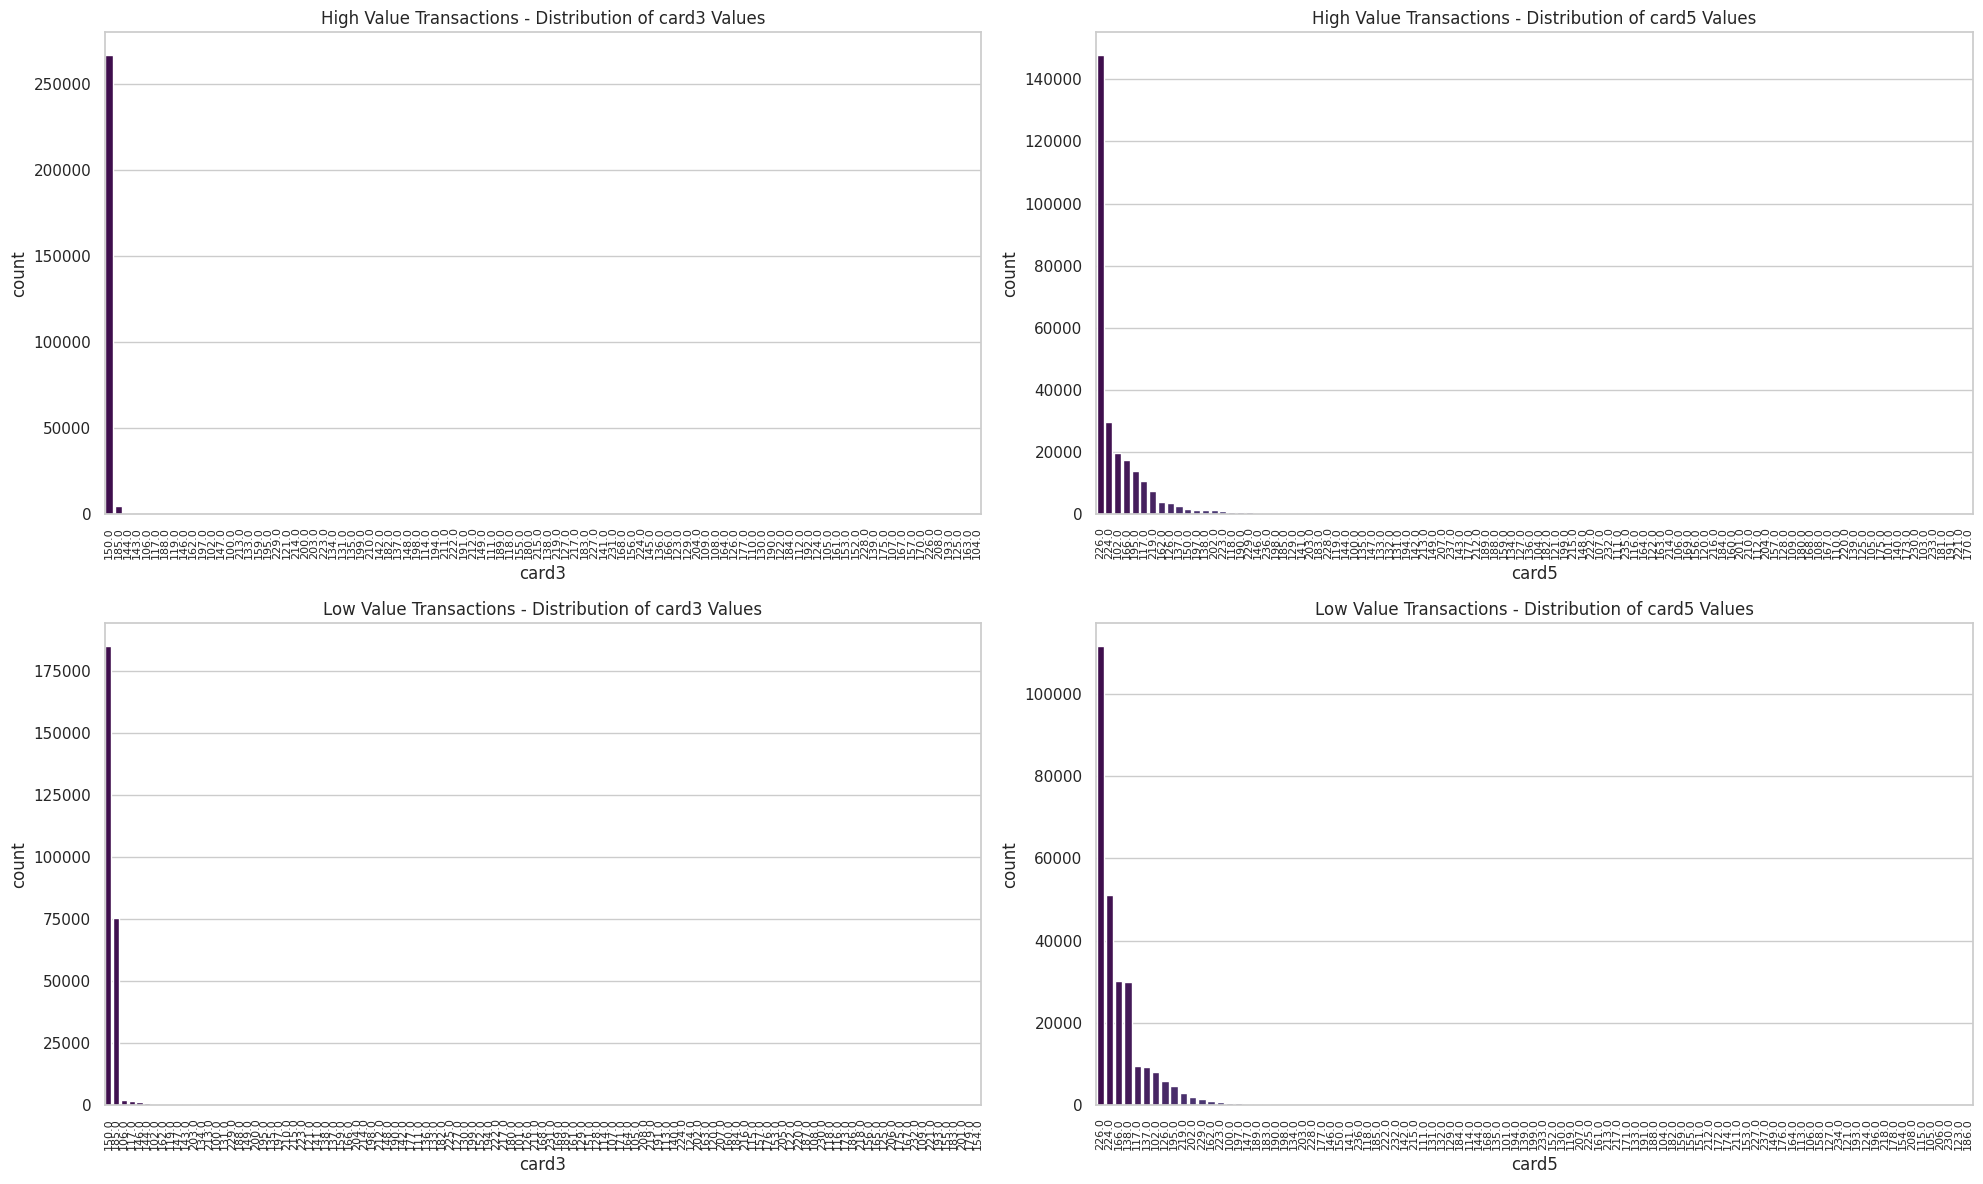

In [44]:
# 상위 25%와 하위 25% 거래 나누기
high_value_threshold = total_trans['TransactionAmt'].quantile(0.75)
low_value_threshold = total_trans['TransactionAmt'].quantile(0.25)

high_value_transactions = total_trans[total_trans['TransactionAmt'] >= high_value_threshold]
low_value_transactions = total_trans[total_trans['TransactionAmt'] <= low_value_threshold]

# card3, card5의 분포 시각화
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.countplot(x='card3', data=high_value_transactions, palette="viridis", order=high_value_transactions['card3'].value_counts().index)
plt.title('High Value Transactions - Distribution of card3 Values')
plt.xticks(rotation=90, fontsize=8)

plt.subplot(2, 2, 2)
sns.countplot(x='card5', data=high_value_transactions, palette="viridis", order=high_value_transactions['card5'].value_counts().index)
plt.title('High Value Transactions - Distribution of card5 Values')
plt.xticks(rotation=90, fontsize=8)

plt.subplot(2, 2, 3)
sns.countplot(x='card3', data=low_value_transactions, palette="viridis", order=low_value_transactions['card3'].value_counts().index)
plt.title('Low Value Transactions - Distribution of card3 Values')
plt.xticks(rotation=90, fontsize=8)

plt.subplot(2, 2, 4)
sns.countplot(x='card5', data=low_value_transactions, palette="viridis", order=low_value_transactions['card5'].value_counts().index)
plt.title('Low Value Transactions - Distribution of card5 Values')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [64]:
total_trans = pd.concat([train_trans, test_trans], axis = 0)

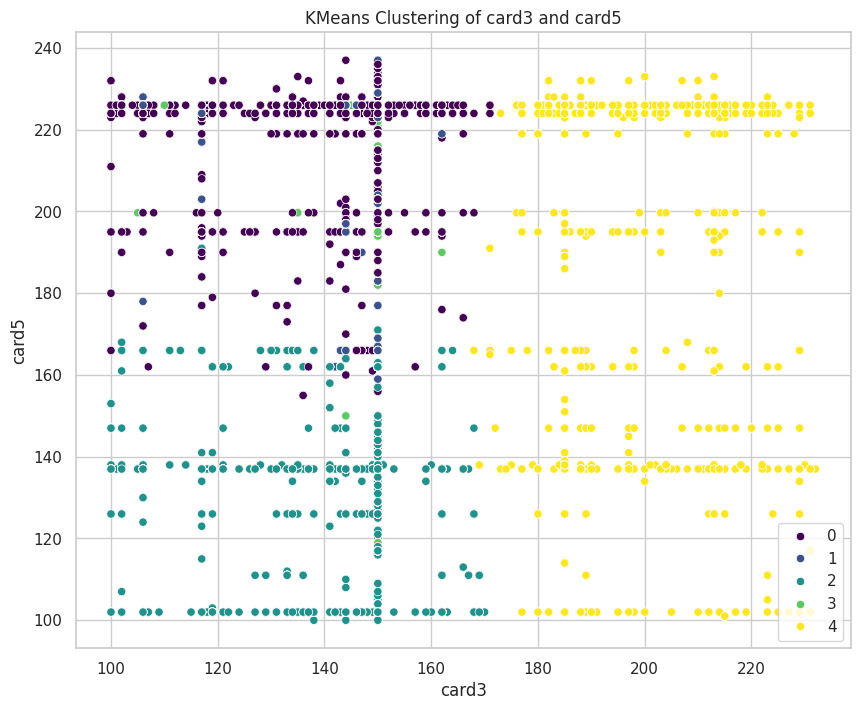

In [68]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 필요한 특성 선택 및 스케일링
features = total_trans[['card3', 'card5', 'card1', 'card2', 'TransactionAmt']].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans 군집화 수행
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# 클러스터 결과 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features['card3'], y=features['card5'], hue=clusters, palette='viridis')
plt.title('KMeans Clustering of card3 and card5')
plt.show()

In [71]:
# 중복된 열 이름 확인
duplicate_columns = total_trans.columns[total_trans.columns.duplicated()].unique()
print(f"중복된 열 이름: {duplicate_columns}")

# 중복된 열 이름 제거
total_trans = total_trans.loc[:,~total_trans.columns.duplicated()]

중복된 열 이름: Index([], dtype='object')


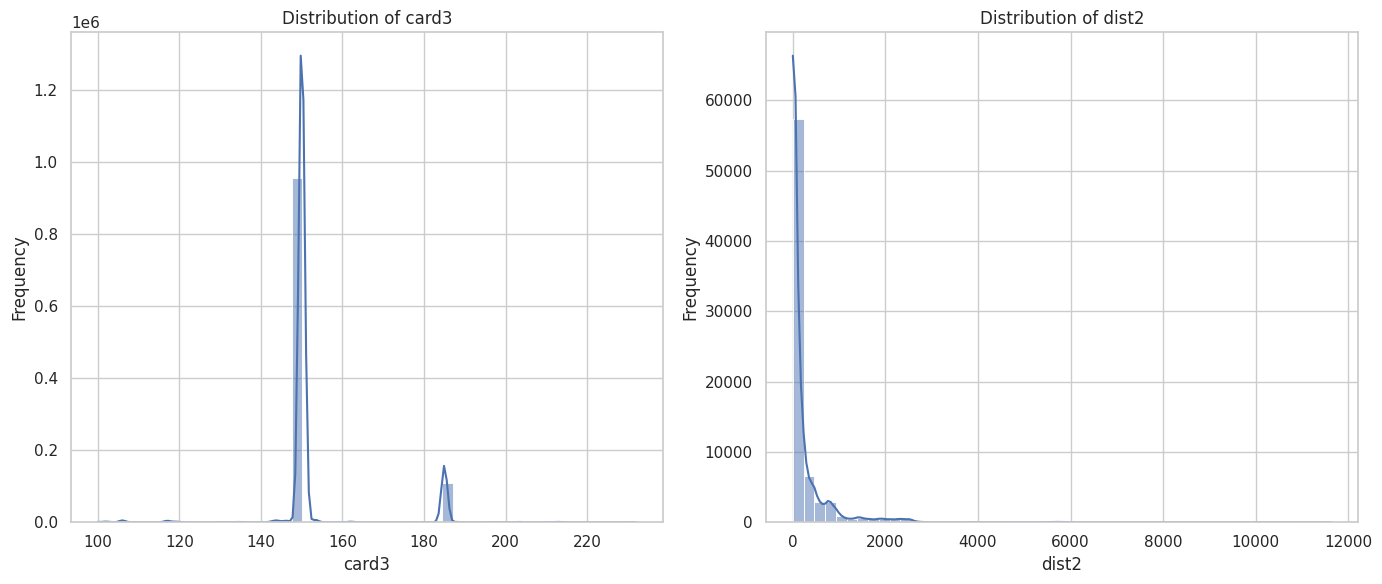

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 그리기
plt.figure(figsize=(14, 6))

# card3 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(total_trans['card3'].dropna(), bins=50, kde=True)
plt.title('Distribution of card3')
plt.xlabel('card3')
plt.ylabel('Frequency')

# dist2 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(total_trans['dist2'].dropna(), bins=50, kde=True)
plt.title('Distribution of dist2')
plt.xlabel('dist2')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

중복된 열 이름: Index([], dtype='object')
중복된 인덱스: Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       506681, 506682, 506683, 506684, 506685, 506686, 506687, 506688, 506689,
       506690],
      dtype='int64', length=506691)


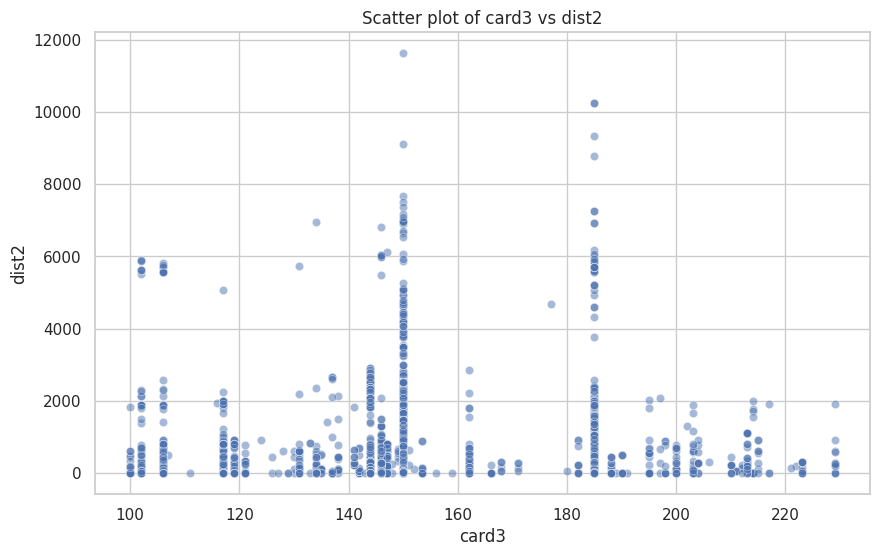

In [75]:

# 중복된 열 이름 확인 및 제거
duplicate_columns = total_trans.columns[total_trans.columns.duplicated()].unique()
print(f"중복된 열 이름: {duplicate_columns}")
total_trans = total_trans.loc[:,~total_trans.columns.duplicated()]

# 중복된 인덱스 확인 및 제거
duplicate_indices = total_trans.index[total_trans.index.duplicated()].unique()
print(f"중복된 인덱스: {duplicate_indices}")
total_trans = total_trans.loc[~total_trans.index.duplicated()]

# 상관관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='card3', y='dist2', data=total_trans, alpha=0.5)
plt.title('Scatter plot of card3 vs dist2')
plt.xlabel('card3')
plt.ylabel('dist2')
plt.show()